## 项目目标

预测自然流失用户，并理解自然流失用户的特点与筛选规则。

## 准备数据

影响活跃用户流失率的因素：
* 在线活跃
* 用户属性（性别，好友数，等级，积分）
* 游戏情况（游戏局数，获胜局数，失利局数，最高牌类型）

这里使用的数据所包含了一周的用户数据，具体的特征有：用户ID、是否流失、性别、登陆总次数、站内好友数、等级、积分、游戏局数、获胜局数、正常牌局、非正常牌局、最高牌类型。

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import xgboost as xgb
import lightgbm as lgb

import warnings
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = ['SimHei']
plt.style.use('ggplot')

import seaborn as sns

## 数据预处理

In [2]:
! ls

card_game_user_churn.ipynb  mydata8258	mydata8258.zip


In [3]:
df = pd.read_csv('./mydata8258/game_data.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   用户id    1309 non-null   int64 
 1   是否流失    1309 non-null   object
 2   性别      1309 non-null   object
 3   登录总次数   1309 non-null   int64 
 4   站内好友数   1309 non-null   int64 
 5   等级      1309 non-null   int64 
 6   积分      1309 non-null   int64 
 7   玩牌局数    1309 non-null   int64 
 8   赢牌局数    1309 non-null   int64 
 9   输牌局数    1309 non-null   int64 
 10  正常牌局    1309 non-null   int64 
 11  非正常牌局   1309 non-null   int64 
 12  最高牌类型   1309 non-null   int64 
dtypes: int64(11), object(2)
memory usage: 133.1+ KB


In [5]:
df.isnull().sum()

用户id     0
是否流失     0
性别       0
登录总次数    0
站内好友数    0
等级       0
积分       0
玩牌局数     0
赢牌局数     0
输牌局数     0
正常牌局     0
非正常牌局    0
最高牌类型    0
dtype: int64

In [6]:
df.head()

,用户id,是否流失,性别,登录总次数,站内好友数,等级,积分,玩牌局数,赢牌局数,输牌局数,正常牌局,非正常牌局,最高牌类型
0,1,是,男,2,1,4,0,27,4,0,0,0,0
1,2,否,男,3,5,6,5,83,40,43,11,0,7
2,3,否,男,3,1,7,8,209,56,153,0,0,8
3,4,是,男,2,0,4,0,15,4,0,16,0,0
4,5,是,男,2,1,4,0,30,3,0,30,0,0


In [7]:
df.drop(['用户id'], axis=1, inplace=True)

df.loc[df['是否流失']=='是', ['是否流失']] = 1
df.loc[df['是否流失']=='否', ['是否流失']] = 0

df.loc[df['性别']=='男', ['性别']] = 1
df.loc[df['性别']=='女', ['性别']] = 0

In [8]:
df[['是否流失', '性别']] = df[['是否流失', '性别']].astype('bool')

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   是否流失    1309 non-null   bool 
 1   性别      1309 non-null   bool 
 2   登录总次数   1309 non-null   int64
 3   站内好友数   1309 non-null   int64
 4   等级      1309 non-null   int64
 5   积分      1309 non-null   int64
 6   玩牌局数    1309 non-null   int64
 7   赢牌局数    1309 non-null   int64
 8   输牌局数    1309 non-null   int64
 9   正常牌局    1309 non-null   int64
 10  非正常牌局   1309 non-null   int64
 11  最高牌类型   1309 non-null   int64
dtypes: bool(2), int64(10)
memory usage: 104.9 KB


In [10]:
df.groupby(['是否流失'])['是否流失'].count()

是否流失
False     291
True     1018
Name: 是否流失, dtype: int64

In [101]:
# add weights due to imbalanced data
w = len(df['是否流失']) / sum(df['是否流失']) - 1

In [12]:
from sklearn.metrics import f1_score
import numpy as np

def f1_eval(y_pred, dtrain):
    y_true = dtrain.get_label()
    err = 1-f1_score(y_true, np.round(y_pred))
    return 'f1_err', err

In [13]:
X = df.drop(['是否流失'], axis=1)
y = df['是否流失']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=32)

## 建立模型

In [103]:
xgb_clf = xgb.XGBClassifier(
    learning_rate=0.05,
    max_depth=8,
    min_child_weight=4,
    objective='binary:logistic',
    random_state=32,
    scale_pos_weight=w,
    silent=True
)

In [104]:
xgb_clf.fit(X_train, y_train, eval_metric=f1_eval)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.05, max_delta_step=0, max_depth=8,
              min_child_weight=4, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=32,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=0.2858546168958742,
              seed=None, silent=True, subsample=1, verbosity=1)

## 评估模型

In [105]:
y_pred = xgb_clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

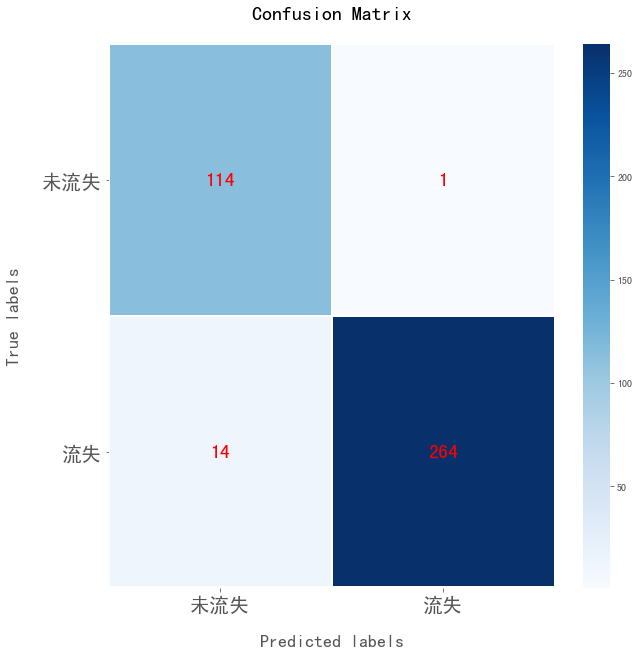

In [106]:
fig, ax = plt.subplots(figsize=(10, 10))

# cmap = sns.cubehelix_palette(start=1.5, rot=3, gamma=0.5, as_cmap=False)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues',
            linewidths=1.5, annot_kws={'size': 20,
                                       'weight': 'bold',
                                       'color': 'red'})

ax.set_xlabel('\nPredicted labels', fontsize=18)
ax.set_ylabel('True labels\n', fontsize=18)
ax.set_title('Confusion Matrix\n', fontsize=20)
plt.setp(ax.get_yticklabels() , rotation = 360)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax.xaxis.set_ticklabels(['未流失', '流失'])
ax.yaxis.set_ticklabels(['未流失', '流失'])
plt.show()

In [18]:
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve

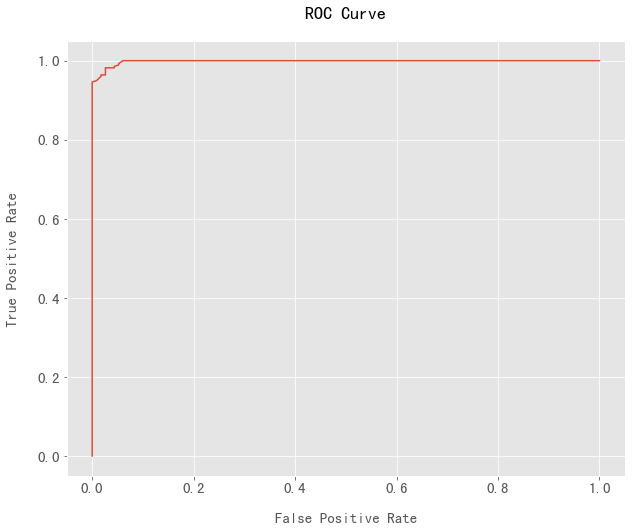

In [108]:
y_score = xgb_clf.predict_proba(X_test)

fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])

# Compute micro-average ROC curve and ROC area
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('\nFalse Positive Rate', fontsize=15)
plt.ylabel('True Positive Rate\n', fontsize=15)
plt.title('ROC Curve\n', fontsize=18, weight='bold')
plt.show()

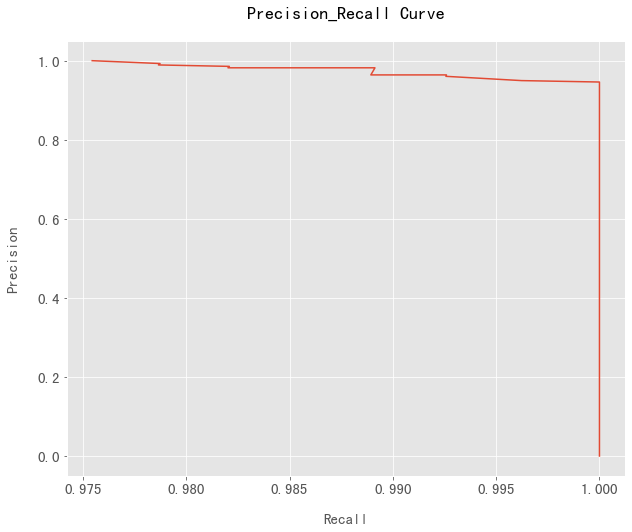

In [109]:
pr, rc, _ = precision_recall_curve(y_test, y_score[:, 1])

# Compute micro-average ROC curve and ROC area
plt.figure(figsize=(10, 8))
plt.plot(pr, rc)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('\nRecall', fontsize=15)
plt.ylabel('Precision\n', fontsize=15)
plt.title('Precision_Recall Curve\n', fontsize=18, weight='bold')
plt.show()

In [24]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [25]:
# Report all the metrics
def report_metrics(y_test, y_pred, y_score):
    pr, rc, _ = precision_recall_curve(y_test, y_score[:, 1])
    print('roc_auc:', ' '*10, roc_auc_score(y_test, y_score[:, 1]))
    print('pr_rc_auc:', ' '*8, auc(rc, pr))
    print('avg_pr_score:', ' '*5, average_precision_score(y_test, y_score[:, 1]))
    print('f1:', ' '*15, f1_score(y_test, y_pred))
    print('accuracy:', ' '*9, accuracy_score(y_test, y_pred))
    print('precision:', ' '*8, precision_score(y_test, y_pred))
    print('recall:', ' '*11, recall_score(y_test, y_pred))

In [110]:
report_metrics(y_test, y_pred, y_score)

roc_auc:            0.9983891147951205
pr_rc_auc:          0.9993319793972524
avg_pr_score:       0.9992882559075575
f1:                 0.9723756906077348
accuracy:           0.9618320610687023
precision:          0.9962264150943396
recall:             0.9496402877697842


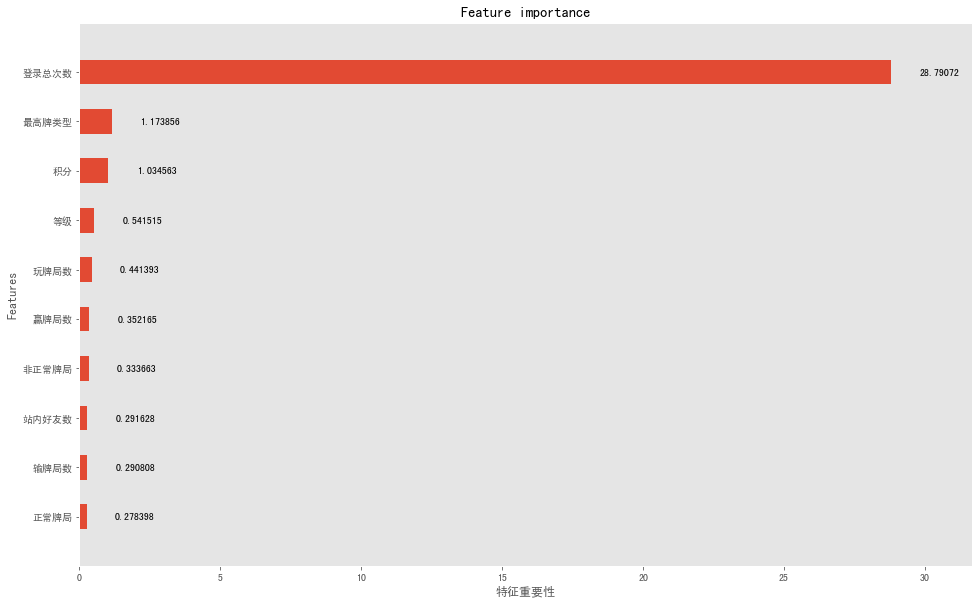

In [111]:
booster = xgb_clf.get_booster()
importance = booster.get_score(importance_type="gain")
for key in importance.keys():
    importance[key] = round(importance[key], 6)

fig, ax = plt.subplots(figsize=(16, 10))
xgb.plot_importance(importance, height=0.5,
                    xlabel='特征重要性', grid=False, ax=ax)
plt.show()

In [28]:
import heapq

In [112]:
heapq.nlargest(5, importance, key=importance.get)

['登录总次数', '最高牌类型', '积分', '等级', '玩牌局数']

In [113]:
{k: v for k, v in sorted(importance.items(),
                         reverse=True,
                         key=lambda x: x[1])[:5]}

{'登录总次数': 28.79072,
 '最高牌类型': 1.173856,
 '积分': 1.034563,
 '等级': 0.541515,
 '玩牌局数': 0.441393}

可见`登录好友数`是最重要的特征，比其他占比大得多，相比之下其他的特征重要值相差不大。由上述的几种特征可以看出当用户参与度的衡量标准对用户流失率的预测虽然没有直接的因果关系，但是也有一定的帮助。

#### 第一个树

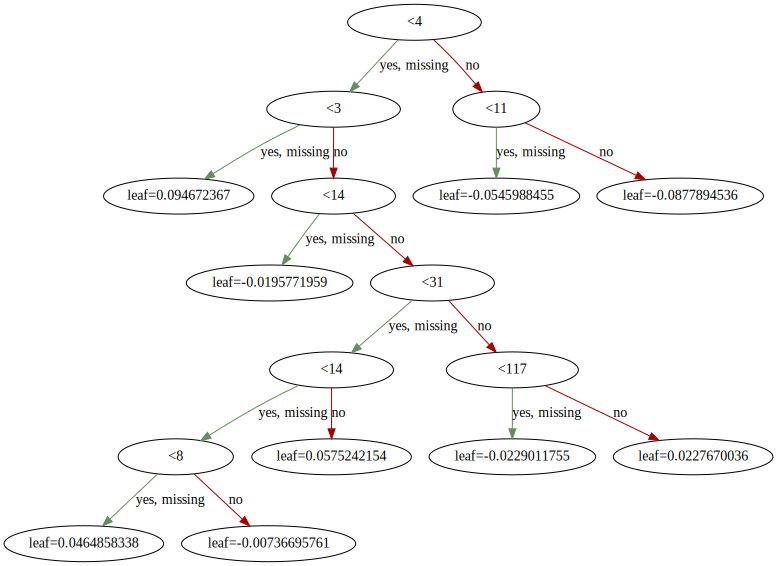

In [31]:
xgb.to_graphviz(xgb_clf, num_trees=1, yes_color='#638e5e', no_color='#a40000')

## 尝试其他模型

In [32]:
import lightgbm as lgb

In [33]:
lgb.__version__

'2.2.3'

In [71]:
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)

parameters = {
    'application': 'binary',
    'objective': 'binary',
    'metric': 'binary_logloss',
    'is_unbalance': 'true',
    'boosting': 'gbdt',
    'num_leaves': 35,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.6,
    'bagging_freq': 20,
    'learning_rate': 0.05,
    'verbose': 0
}

In [72]:
model = lgb.train(parameters,
                  train_data,
                  valid_sets=test_data,
                  num_boost_round=5000,
                  early_stopping_rounds=100)

[1]	valid_0's binary_logloss: 0.58491
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.538714
[3]	valid_0's binary_logloss: 0.500539
[4]	valid_0's binary_logloss: 0.467702
[5]	valid_0's binary_logloss: 0.439037
[6]	valid_0's binary_logloss: 0.41247
[7]	valid_0's binary_logloss: 0.389418
[8]	valid_0's binary_logloss: 0.375441
[9]	valid_0's binary_logloss: 0.355631
[10]	valid_0's binary_logloss: 0.33803
[11]	valid_0's binary_logloss: 0.321064
[12]	valid_0's binary_logloss: 0.305504
[13]	valid_0's binary_logloss: 0.291232
[14]	valid_0's binary_logloss: 0.278214
[15]	valid_0's binary_logloss: 0.266044
[16]	valid_0's binary_logloss: 0.254705
[17]	valid_0's binary_logloss: 0.244593
[18]	valid_0's binary_logloss: 0.234597
[19]	valid_0's binary_logloss: 0.225589
[20]	valid_0's binary_logloss: 0.21739
[21]	valid_0's binary_logloss: 0.209483
[22]	valid_0's binary_logloss: 0.206295
[23]	valid_0's binary_logloss: 0.199257
[24]	valid_0's binary_logloss:

In [73]:
y_score = model.predict(X_test)
y_test = y_score > 0.5

In [74]:
cm = confusion_matrix(y_test, y_pred)

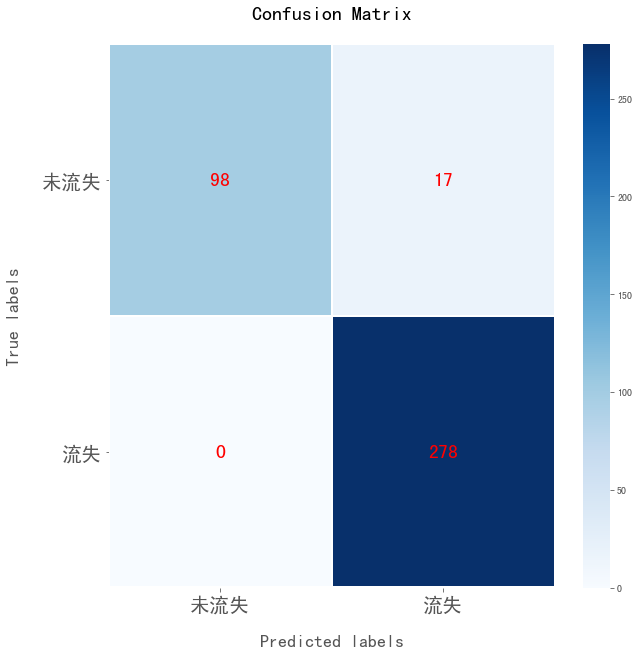

In [75]:
fig, ax = plt.subplots(figsize=(10, 10))

sns.heatmap(cm, annot=True, fmt='g', cmap='Blues',
            linewidths=1.5, annot_kws={'size': 20,
                                       'weight': 'bold',
                                       'color': 'red'})

ax.set_xlabel('\nPredicted labels', fontsize=18)
ax.set_ylabel('True labels\n', fontsize=18)
ax.set_title('Confusion Matrix\n', fontsize=20)
plt.setp(ax.get_yticklabels() , rotation = 360)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax.xaxis.set_ticklabels(['未流失', '流失'])
ax.yaxis.set_ticklabels(['未流失', '流失'])
plt.show()

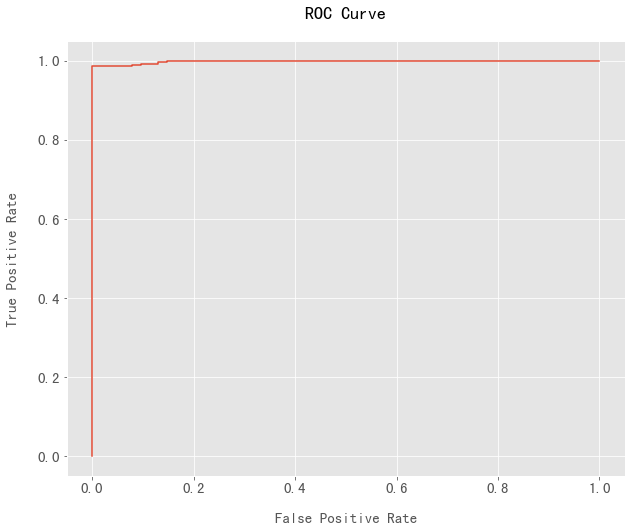

In [76]:
y_score = xgb_clf.predict_proba(X_test)

fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])

# Compute micro-average ROC curve and ROC area
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('\nFalse Positive Rate', fontsize=15)
plt.ylabel('True Positive Rate\n', fontsize=15)
plt.title('ROC Curve\n', fontsize=18, weight='bold')
plt.show()

In [77]:
report_metrics(y_test, y_pred, y_score)

roc_auc:            0.9983734751329371
pr_rc_auc:          0.9993549499492043
avg_pr_score:       0.9993560624149811
f1:                 0.9703315881326353
accuracy:           0.9567430025445293
precision:          0.9423728813559322
recall:             1.0


可以看到LightGBM的表现在几乎在各方面都优于XGBoost，相对来讲LightGBM有更多的一类误差（Type I Error），而XGBoost有更多的二类误差（Type II Error），这可能是因为LightGBM对不平衡的数据有更好的支持。

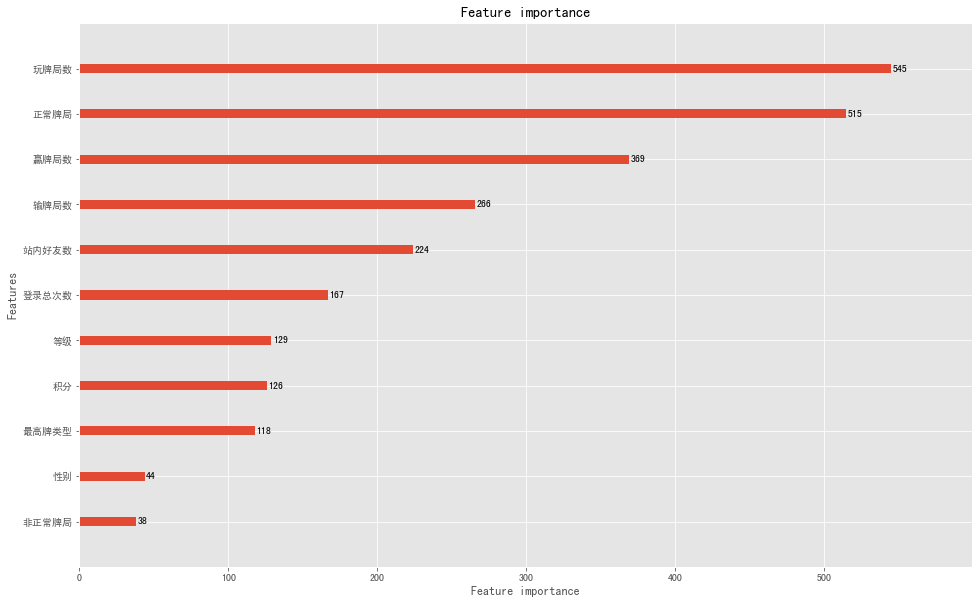

In [84]:
lgb.plot_importance(model, figsize=(16, 10))
plt.show()

In [100]:
importance = dict(zip(X_train.columns, model.feature_importance()))

In [98]:
{k: v for k, v in sorted(importance.items(),
                         reverse=True,
                         key=lambda x: x[1])[:5]}

{'玩牌局数': 545, '正常牌局': 515, '赢牌局数': 369, '输牌局数': 266, '站内好友数': 224}

可以看到在这里重要的特征之间重要值差值不大，和XGBoost相比较为不同，更侧重于用户参与的指标。

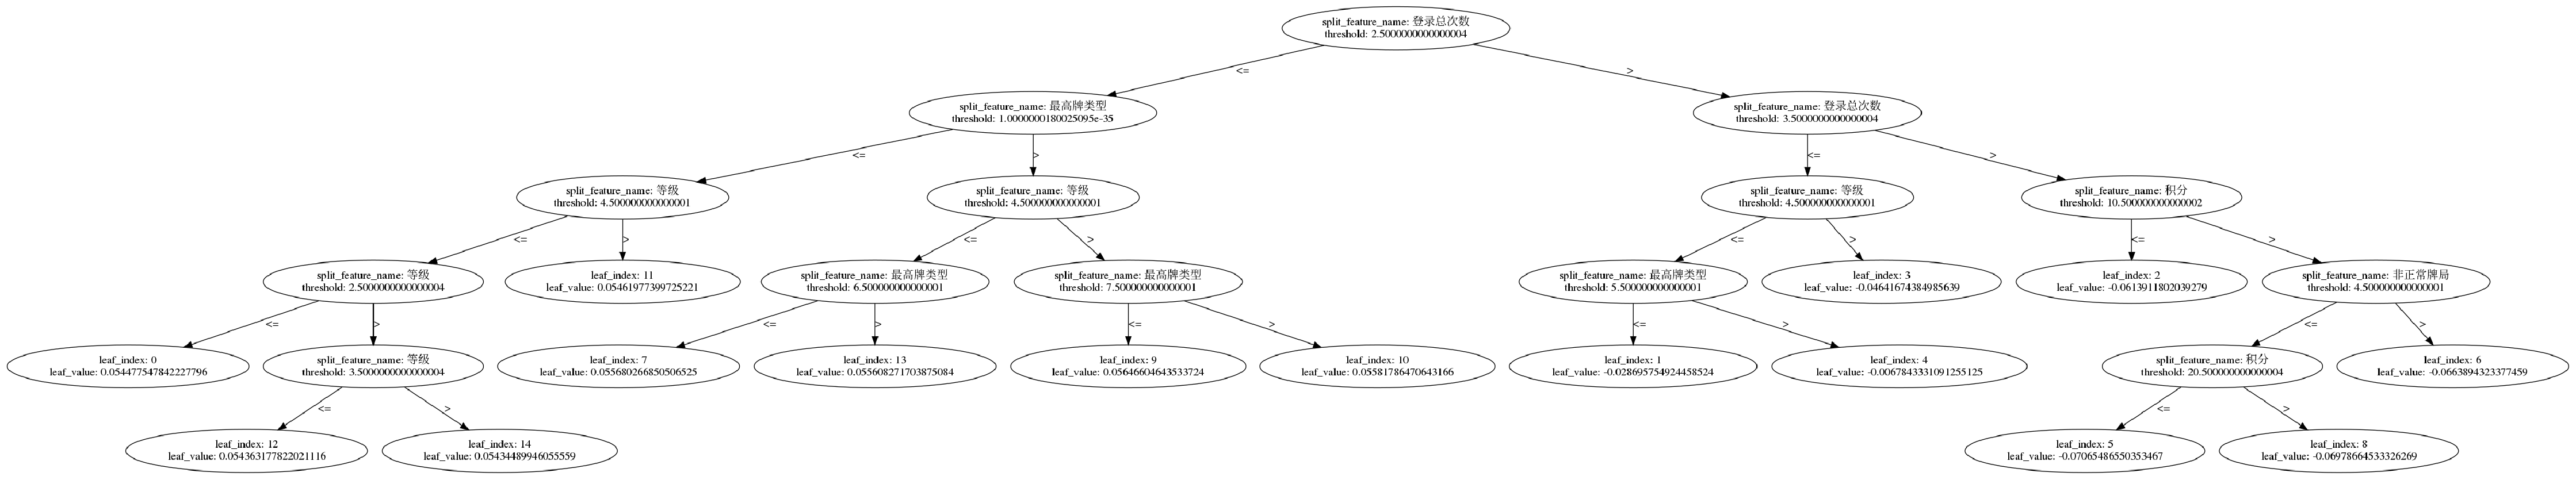

In [91]:
lgb.plot_tree(model, tree_index=20, figsize=(80, 60))
plt.show()

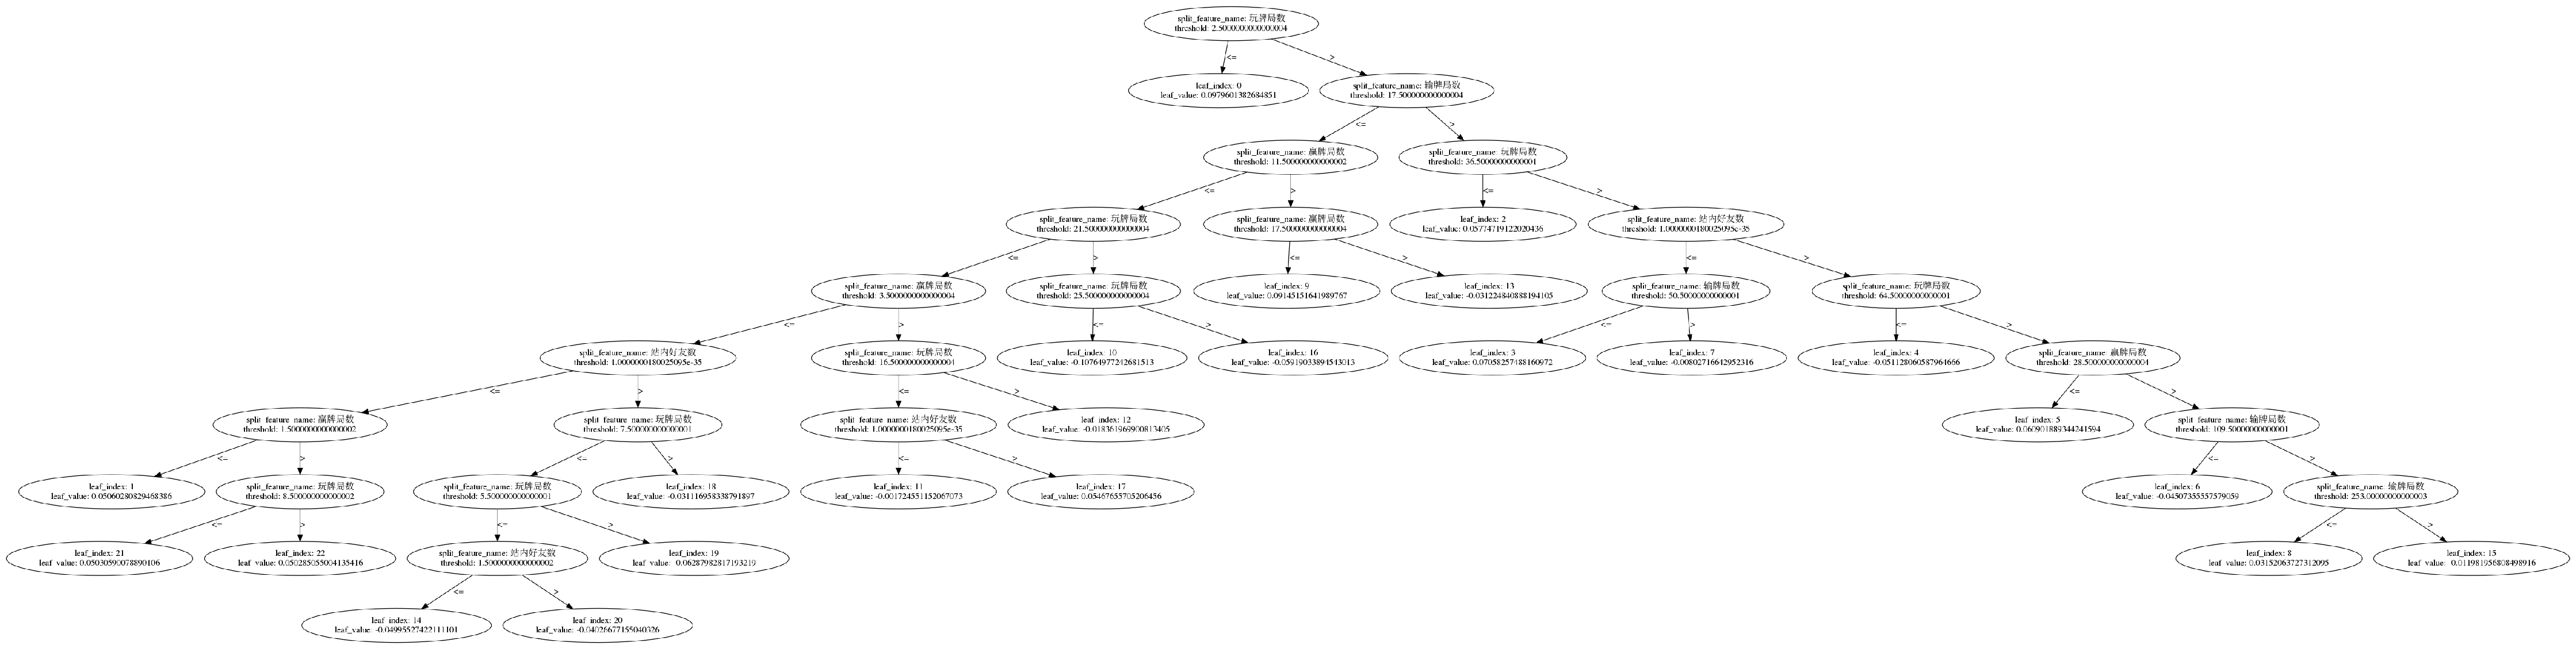

In [92]:
lgb.plot_tree(model, tree_index=90, figsize=(80, 60))
plt.show()